In [1]:
import numpy as np
from skimage.io import imread
import skimage.transform
import pickle

In [2]:
from io import BytesIO
from PIL import Image as PIL_Image
import numpy as np
from IPython.display import display, Image

def display_img_array(ima, **kwargs):
    if ima.dtype == np.float32 or ima.dtype == np.float64:
        ima = (np.clip(ima, 0., 1.)*255).astype(np.uint8)
    im = PIL_Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', **kwargs))

In [3]:
import theano
import theano.tensor as T
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except:
    print("unable to import Conv2DDNNLayer, use Conv2DLayer instead")
    from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX
from lasagne.layers import *
import lasagne

Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)
/usr/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
def load_vgg19():
    net = {}
    net['input'] = InputLayer((1, 3, None, None))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')
    if bytes == str:
    # Python 2
        values = pickle.load(open('vgg19_normalized.pkl', 'rb'))['param values']
    else:
        #Python 3
        values = pickle.load(open('vgg19_normalized.pkl', 'rb'), encoding='latin1')['param values']
    lasagne.layers.set_all_param_values(net['pool5'], values)
    return net
net = load_vgg19()

In [5]:
feature_layer = net['conv4_1']
feature_output = get_output(feature_layer)
net_input = net['input'].input_var

In [6]:
from skimage.color import gray2rgb, rgb2gray
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
BGR = False
def prep_image(im, IMAGE_W, IMAGE_H, BGR=BGR, bw=False):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h*IMAGE_W < w*IMAGE_H:
        im = skimage.transform.resize(im, (IMAGE_H, w*IMAGE_H//h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W//w, IMAGE_W), preserve_range=True)        

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_H//2:h//2+IMAGE_H//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]    
    rawim = im.astype('uint8')
    # Shuffle axes to c01
    if bw:
        if BGR:
            im = im[:,:,::-1]
        bwim = gray2rgb(rgb2gray(im))
        im = (bwim*bw+im.astype("float64")*(1.-bw))
        if BGR:
            im = im[:,:,::-1]
    
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    if not BGR:
        im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

In [7]:
def show_layer(x):    
    x = np.swapaxes(np.swapaxes(x[0,:3], 0, 1), 1, 2)    
    x = np.clip(x*255, 0, 255).astype('uint8')
    return x

In [70]:
from skimage import exposure
img0 = imread("img/smile_face.jpg")
img0 = img0[0:400, 200:800]
img0 = imread('img/tjw3.jpg')
#img0 = imread('img/brad_pitt.jpg')
#img0 = imread("anime_face_by_rayshar-d702kab.jpg")
#p2, p90 = np.percentile(img0, (10, 80))
#img0 = exposure.rescale_intensity(img0, in_range=(p2, p90))
#img0 = (img0*255).astype('uint8')
#img0 = imread("img/Paris-Musee-DOrsay-Vincent-van-Gogh-1889-Self-Portrait-2-Close-Up.jpg")
#img0 = imread("18500729_10.jpg")
#img0 = imread("anime-girl-face-nice-smile.jpg")
#img0 = imread("d1381867.jpg")
img0 = imread("2015122760189693.jpg")
#img0=imread("f1277177042919.JPG")

raw_photo, photo = prep_image(img0, 640, 480, 0.)
photo_feature = feature_output.eval({net_input:photo})

img1 = imread("img/Paris-Musee-DOrsay-Vincent-van-Gogh-1889-Self-Portrait-2-Close-Up.jpg")
img1 = imread("501040_0.jpg")
#img1 = imread("anime_face_by_rayshar-d702kab.jpg")
#img1 = imread("img/picasso_selfport1907.jpg")
#img1 = imread('img/brad_pitt.jpg')
#img1 = imread('img/tjw1.jpg')
img1 = imread("18500729_10.jpg")
#img1 = imread("anime-girl-face-nice-smile.jpg")
img1 = imread("simpsguestmain.jpg")
#img1 = imread("flanders.png")[:,:,:3]

raw_style, style = prep_image(img1, 640, 480, 0.)
style_feature = feature_output.eval({net_input:style})

In [9]:
C = style_feature.shape[1]
S = style.shape[3]//style_feature.shape[3]
PSIZE = (25//S)*2+1
PSIZE = 7
print(S,C, PSIZE)

8 512 7


In [10]:
NUM_FILTERS = 80-PSIZE+1

In [11]:
def unwrap(a):
    return np.swapaxes(np.swapaxes(a[0],0,1),1,2)

In [12]:
# compute norm
input_img = T.tensor4()
layer_img = InputLayer((1, C, None, None), input_var=input_img)
layer_sqr_sum = ExpressionLayer(layer_img,  lambda x:T.sum(T.sqr(x), axis=1,keepdims=True) , output_shape=(1,1,None,None))
layer_norm = ConvLayer(layer_sqr_sum, 1, PSIZE, pad='valid', W=floatX(np.ones((1, 1, PSIZE,PSIZE))), b=None, nonlinearity=T.sqrt)
layer_norm_reshape = ReshapeLayer(layer_norm, ([2], [3]))

In [13]:
# compute correlation
input_patch = T.tensor4()
#layer_patch = InputLayer((NUM_FILTERS, C, PSIZE, PSIZE), input_var=input_patch)
patch_sqr_sum = (input_patch**2).sum(axis=3).sum(axis=2).sum(axis=1).reshape((1, NUM_FILTERS, 1, 1))
layer_prod= ConvLayer(layer_img, NUM_FILTERS, PSIZE, pad='valid', W=input_patch, b=None, nonlinearity=None)
layer_corr = ElemwiseMergeLayer([layer_prod, layer_norm_reshape], lambda a,b: (a/b)/patch_sqr_sum)
layer_corr_output = lasagne.layers.get_output(layer_corr)

In [14]:
# Pack into a function to find the Nearest Neighbor
best_match = theano.function([input_img, input_patch], T.max_and_argmax(layer_corr_output, axis=(2,3))+[T.shape(layer_corr_output)])

In [71]:
patches = np.zeros( shape=(NUM_FILTERS, photo_feature.shape[1], PSIZE, PSIZE) ,  dtype= photo_feature.dtype)
H = photo_feature.shape[2]-PSIZE+1
mapping_idx = np.zeros((H,NUM_FILTERS), dtype='int64')
mapping_weight = np.zeros((H,NUM_FILTERS), dtype='float32')
for j in range(H):
    for n in range(NUM_FILTERS):            
            patches[n] = photo_feature[0, :, j:j+PSIZE,n:n+PSIZE ]  
    m, idx, s = best_match(style_feature, patches)
    mapping_idx[j] =idx
    mapping_weight[j] = m
mapping_weight[:] = mapping_weight**2

In [72]:
preview_method = ('max', 'average')[1]
preview = np.zeros(raw_photo.shape)
preview_weight = np.zeros(raw_photo.shape)
for j in range(H):
    for n in range(NUM_FILTERS):
        y,x = np.unravel_index(mapping_idx[j,n], s[2:])
        _preview = preview[j*S:(j+PSIZE)*S, n*S:(n+PSIZE)*S]
        _preview_weight = preview_weight[j*S:(j+PSIZE)*S, n*S:(n+PSIZE)*S]  
        if preview_method == 'max':
            _preview[...] = np.where(_preview_weight < mapping_weight[j,n], raw_style[y*S:(y+PSIZE)*S, x*S:(x+PSIZE)*S], _preview)        
            _preview_weight[...]=np.where(_preview_weight < mapping_weight[j,n], mapping_weight[j,n], _preview_weight)
        else:
            _preview[...] += mapping_weight[j,n]*raw_style[y*S:(y+PSIZE)*S, x*S:(x+PSIZE)*S]
            _preview_weight[...] += mapping_weight[j,n]
print(preview_weight.min())
if preview_method == 'average':
    preview /= preview_weight

1.39679032145e-05


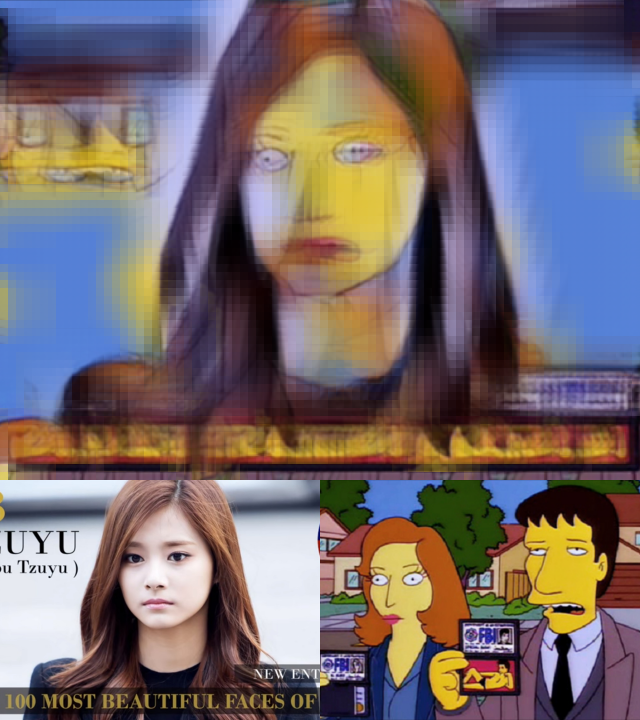

In [73]:
combine_src = skimage.transform.rescale(np.hstack([raw_photo, raw_style]), 0.5)
out = np.vstack([preview/255, combine_src])
display_img_array(out)

In [18]:
raw_preview, previewx = prep_image(preview.astype('uint8'), 640, 480, 0.)
photo_feature = feature_output.eval({net_input:previewx})

In [19]:
def mark_img(raw, yx, colors):
    disp = raw.copy()
    for (y,x), color in zip(yx, colors):        
        arr = disp[y*S:(y+PSIZE)*S,x*S:(x+PSIZE)*S]
        disp[y*S:(y+PSIZE)*S,x*S:(x+PSIZE)*S] = ((arr+np.array(color))/2).astype('uint8')
    return disp

In [20]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
#style_layers = ['conv4_1']
layers = {k: net[k] for k in content_layers+style_layers}

In [21]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    loss = 1./2 * lasagne.objectives.squared_error(x, p).sum()
    return loss


def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)).sum()


In [22]:
def get_img(i):
    return imread(i) if isinstance(i, str) else i   
shared_mem = {}
func_mem = {}
outputs_mem = {}

def Func(i, In, Out, updates=None):
    if i not in func_mem:
        func_mem[i] = theano.function(In, Out, updates=updates)
    return func_mem[i]

def Eval(i, Out):
    return Func(i, [], Out)()

def Shared(i, v):
    if i in shared_mem:
        shared_mem[i].set_value(v)
    else:
        shared_mem[i]=theano.shared(v)
    return shared_mem[i]

In [23]:
IMAGE_W, IMAGE_H = 640, 480
raw_content, content = prep_image(get_img(img0), IMAGE_W, IMAGE_H)
raw_style, style = prep_image(get_img(img1), IMAGE_W, IMAGE_H)
input_image = Shared((IMAGE_W, "input"), style)
outputs = lasagne.layers.get_output(layers.values(), input_image)

In [24]:
input_image.set_value(style)
style_features = {k: Shared((IMAGE_W, "style_"+k), Eval((IMAGE_W, k), output)) for k, output in zip(layers.keys(), outputs)}

In [25]:
input_image.set_value(content)
content_features = {k: Shared((IMAGE_W, "content_"+k), Eval((IMAGE_W, k), output)) for k, output in zip(layers.keys(), outputs)}

/home/tjw/.local/lib/python3.4/site-packages/scikit_image-0.13dev-py3.4-linux-x86_64.egg/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


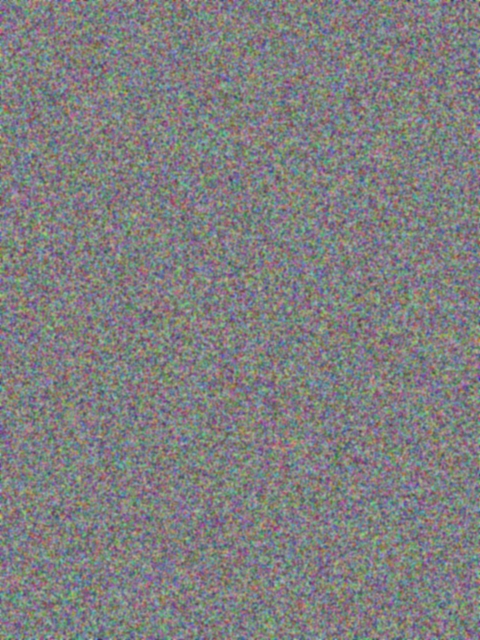

In [26]:
import skimage.filters
generated_image = input_image
init_img = skimage.filters.gaussian(np.random.uniform(-128, 128, (IMAGE_W, IMAGE_H, 3)), 1)
display_img_array( (init_img+128).astype('uint8'))
init_img = np.swapaxes(init_img, 0,2).reshape(1,3,IMAGE_H, IMAGE_W)
#generated_image.set_value(floatX(init_img))
generated_image.set_value(previewx)
gen_features = {k: v for k, v in zip(layers.keys(), outputs)}   

In [27]:
style_a = {}
style_a2 = {}
for k,a in style_features.items():    
    npa = np.array(a.eval())
    s = a.shape.eval()
    S = s[3]//photo_feature.shape[3]
    W = s[3]//S-PSIZE+1
    H = s[2]//S-PSIZE+1
    C=s[1]
    npA =  floatX(np.zeros_like(npa))
    npW =  floatX(np.zeros_like(npa))
    A2 = floatX(np.zeros_like(npa))
    for j in range(H):
        for i in range(W):
            py,px = np.unravel_index(mapping_idx[j,i], (H,W))
            weight = mapping_weight[j,i]
            # print(j, i, py, px)
            npA[:, :, j*S:(j+PSIZE)*S, i*S:(i+PSIZE)*S] += weight * npa[0, :, py*S:(py+PSIZE)*S, px*S:(px+PSIZE)*S]
            npW[:, :, j*S:(j+PSIZE)*S, i*S:(i+PSIZE)*S] += weight
            A2[:,:, j*S:(j+PSIZE)*S, i*S:(i+PSIZE)*S] += weight * (npa[0, :, py*S:(py+PSIZE)*S, px*S:(px+PSIZE)*S]**2)
    #npA=npA.flatten()    
    A = Shared((IMAGE_W, 'A_'+k), npA/npW)
    style_a[k] = A
    style_a2[k] = (A2/npW).sum()

In [28]:
def style_loss(A, A2, X, layer):    
    a = A[layer]
    a2 = A2[layer]
    x = X[layer]
    s = x.shape.eval()
    loss = (x**2).sum()+a2-2*(x*a).sum()
    return loss/(s[1]*s[2]*s[3])

In [29]:
#tv_loss = 0.1e-7 * total_variation_loss(generated_image) 
tv_loss = 0.1e-7 * total_variation_loss(generated_image) 
c_loss = 0.
for layer in content_layers:
       c_loss += 3 * 0.001 * content_loss(content_features, gen_features, layer)
s_loss = 0.
for layer in style_layers:
        s_loss += 0.2e6 * style_loss(style_a, style_a2,  gen_features, layer)
total_loss = tv_loss + c_loss+ s_loss
f_errors = Func((IMAGE_W, 'errors'), [], [tv_loss, c_loss, s_loss])

In [30]:
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    #x0 = floatX(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
    #generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [31]:
grad = T.grad(total_loss, generated_image)
# Theano functions to evaluate loss and gradient
f_loss = Func((IMAGE_W, "loss"), [], total_loss)        
f_grad = Func((IMAGE_W, "grad"), [], grad)        
x0 = generated_image.get_value().astype('float64')

In [32]:
def deprocess(x, BGR=BGR):
    x = np.copy(x[0])
    x += MEAN_VALUES
    if not BGR:
        x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [33]:
import scipy.optimize

In [34]:
from IPython.display import clear_output

24 333419.1791178386 [0.6579686999320984, 2910.97314453125, 330507.548014323]


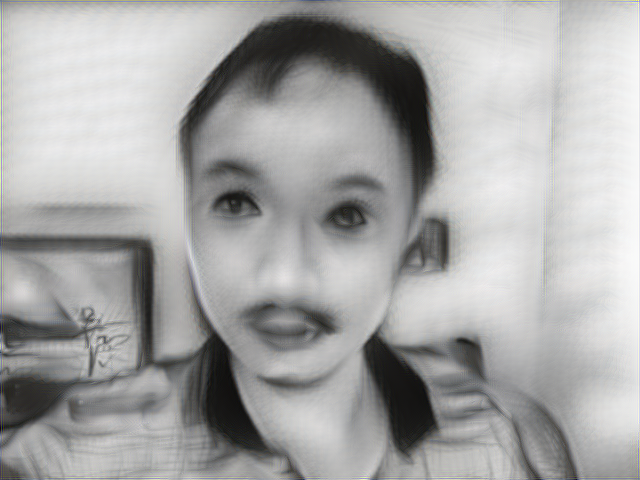

In [35]:
for i in range(25):
    x, loss, d = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)    
    x0 = generated_image.get_value().astype('float64')    
    errors = [float(x) for x in f_errors()]
    clear_output()
    print(i, loss, errors)
    display_img_array(deprocess(x0))

In [36]:
d

{'funcalls': 17,
 'grad': array([-0.00013013, -0.00015229,  0.00044767, ..., -0.00012417,
         0.00017038, -0.00017763]),
 'nit': 1,
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'warnflag': 0}

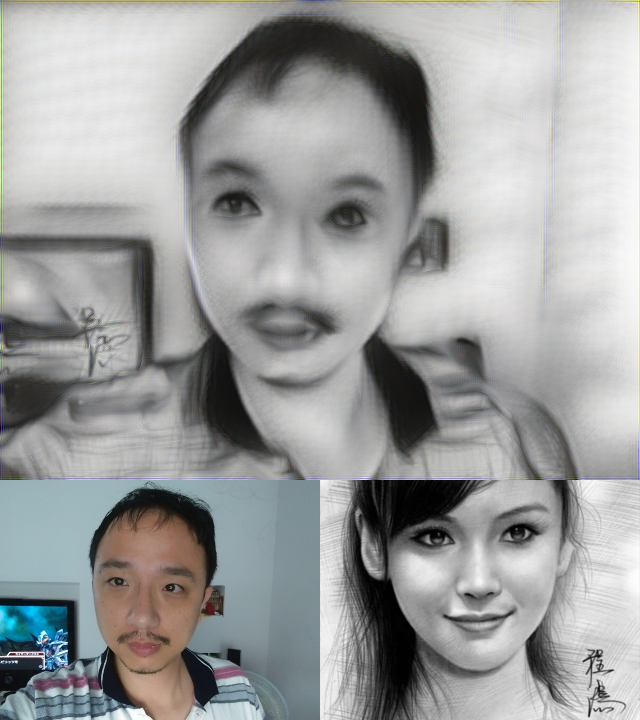

In [38]:
combine_src = skimage.transform.rescale(np.hstack([raw_photo, raw_style]), 0.5)
out = np.vstack([deprocess(x0)/255, combine_src])
display_img_array(out)
















